In [1]:

!pip install -q segmentation_models_pytorch

import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
import segmentation_models_pytorch as smp
import random
import glob
import time
import matplotlib.pyplot as plt


OUTPUT_DIR = '/kaggle/working'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(" Libraries Installed & Ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency r

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

 Libraries Installed & Ready.


In [2]:
SEARCH_ROOT = '/kaggle/input'
print(" Searching for data in /kaggle/input...")

def find_data_paths(root_dir, split_name):
    # Search recursively
    split_folders = glob.glob(f"{root_dir}/**/{split_name}", recursive=True)
    if not split_folders:
        split_folders = glob.glob(f"{root_dir}/**/{split_name.lower()}", recursive=True)
    
    if not split_folders:
        return None, None
    
    target_dir = split_folders[0]
    
    # Sub-search for Images/Masks (Handles 'Segmentation', 'Masks', 'Labels' etc)
    def get_subfolder(parent, candidates):
        for item in os.listdir(parent):
            if os.path.isdir(os.path.join(parent, item)):
                for c in candidates:
                    if c in item.lower():
                        return os.path.join(parent, item)
        return None

    img_dir = get_subfolder(target_dir, ['images', 'rgb', 'color'])
    mask_dir = get_subfolder(target_dir, ['masks', 'segmented', 'labels', 'segment'])
    return img_dir, mask_dir

# Execute Finder
x_train_dir, y_train_dir = find_data_paths(SEARCH_ROOT, 'Train')
try:
    x_val_dir, y_val_dir = find_data_paths(SEARCH_ROOT, 'Val')
except:
    x_val_dir, y_val_dir = x_train_dir, y_train_dir

if not x_train_dir:
    print(" ERROR: Data not found!")
    print(" Solution: Click 'Add Data' on the right sidebar and upload your Zip file.")
    raise FileNotFoundError("Dataset missing.")

print(f" Data Found:\n   Images: {x_train_dir}\n   Masks: {y_train_dir}")

 Searching for data in /kaggle/input...
 Data Found:
   Images: /kaggle/input/offroad-data/Offroad_Segmentation_Training_Dataset/train/Color_Images
   Masks: /kaggle/input/offroad-data/Offroad_Segmentation_Training_Dataset/train/Segmentation


In [3]:

CLASS_DICT = {
    "Trees": 100, "Lush Bushes": 200, "Dry Grass": 300, "Dry Bushes": 500,
    "Ground Clutter": 550, "Flowers": 600, "Logs": 700, "Rocks": 800,
    "Landscape": 7100, "Sky": 10000
}
ID_TO_INDEX = {v: k for k, v in enumerate(CLASS_DICT.values())}

def map_mask_to_indices(mask_array):
    # FIX: Replaced np.long with np.int64
    mask_indices = np.zeros(mask_array.shape, dtype=np.int64)
    for original_id, new_index in ID_TO_INDEX.items():
        mask_indices[mask_array == original_id] = new_index
    return mask_indices

class OffroadDataset(Dataset):
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        self.ids = sorted(os.listdir(images_dir))
        
        # 100% DATA MODE (No Frame Skipping)
        print(f" Loaded {len(self.ids)} images (100% Full Data).")

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # Read Image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Read Mask (16-bit Fix)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = map_mask_to_indices(mask)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image)
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        return image, mask.long()

    def __len__(self):
        return len(self.ids)

In [4]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda' # GPU ENABLED
BATCH_SIZE = 16 # Optimized for P100

# Augmentations (Best Image Quality)
def get_training_augmentation():
    return albu.Compose([
        albu.PadIfNeeded(min_height=320, min_width=320, border_mode=0, p=1),
        albu.RandomCrop(height=320, width=320, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.Affine(scale=(0.9, 1.1), rotate=(-10, 10), p=0.5),
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    return albu.Compose([albu.Lambda(image=preprocessing_fn), albu.Lambda(image=to_tensor)])

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

print(" Preparing Loaders...")
train_dataset = OffroadDataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = OffroadDataset(x_val_dir, y_val_dir, augmentation=None, preprocessing=get_preprocessing(preprocessing_fn))

# num_workers=2 speeds up data loading on Kaggle
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

# Initialize Model
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=len(CLASS_DICT), activation=None)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(" Model Loaded on GPU.")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

 Preparing Loaders...
 Loaded 2857 images (100% Full Data).
 Loaded 317 images (100% Full Data).


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

 Model Loaded on GPU.


In [5]:
EPOCHS = 20
print(f"\n Starting GPU Training ({EPOCHS} Epochs)")
print("  This should take ~2-3 minutes per epoch on Kaggle GPU.")

model.to(DEVICE)
best_iou = 0.0

def compute_iou(pred, target):
    pred = torch.argmax(pred, dim=1).view(-1)
    target = target.view(-1)
    intersection = (pred == target).sum().item()
    union = len(pred) 
    return intersection / union

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(DEVICE) # Move data to GPU
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    # Validation
    model.eval()
    val_ious = []
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            val_ious.append(compute_iou(outputs, masks))
    
    avg_loss = epoch_loss / len(train_loader)
    mean_iou = np.nanmean(val_ious)
    
    elapsed = (time.time() - start_time) / 60
    print(f" Epoch {epoch+1}/{EPOCHS} | Time: {elapsed:.1f}m | Loss: {avg_loss:.4f} | IoU: {mean_iou:.4f}")
    
    # Save Best Model to Output Directory
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_model.pth')
        print(f"    New Best Model Saved! (IoU: {best_iou:.4f})")

print(f"\n Training Finished! Final Best IoU: {best_iou:.4f}")


 Starting GPU Training (20 Epochs)
  This should take ~2-3 minutes per epoch on Kaggle GPU.
 Epoch 1/20 | Time: 5.1m | Loss: 1.2320 | IoU: 0.8271
    New Best Model Saved! (IoU: 0.8271)
 Epoch 2/20 | Time: 4.0m | Loss: 0.7287 | IoU: 0.8386
    New Best Model Saved! (IoU: 0.8386)
 Epoch 3/20 | Time: 3.3m | Loss: 0.5909 | IoU: 0.8581
    New Best Model Saved! (IoU: 0.8581)
 Epoch 4/20 | Time: 3.3m | Loss: 0.5325 | IoU: 0.8642
    New Best Model Saved! (IoU: 0.8642)
 Epoch 5/20 | Time: 3.2m | Loss: 0.4804 | IoU: 0.8718
    New Best Model Saved! (IoU: 0.8718)
 Epoch 6/20 | Time: 3.1m | Loss: 0.4450 | IoU: 0.8701
 Epoch 7/20 | Time: 3.0m | Loss: 0.4260 | IoU: 0.8685
 Epoch 8/20 | Time: 3.0m | Loss: 0.4271 | IoU: 0.8762
    New Best Model Saved! (IoU: 0.8762)
 Epoch 9/20 | Time: 3.2m | Loss: 0.4226 | IoU: 0.8585
 Epoch 10/20 | Time: 3.2m | Loss: 0.4039 | IoU: 0.8821
    New Best Model Saved! (IoU: 0.8821)
 Epoch 11/20 | Time: 3.2m | Loss: 0.3777 | IoU: 0.8873
    New Best Model Saved! (IoU:

 'val_loader' or 'model' not found. Recreating them now...
 Recovery Complete.
 Loaded 'best_model.pth'
Displaying Visualization...


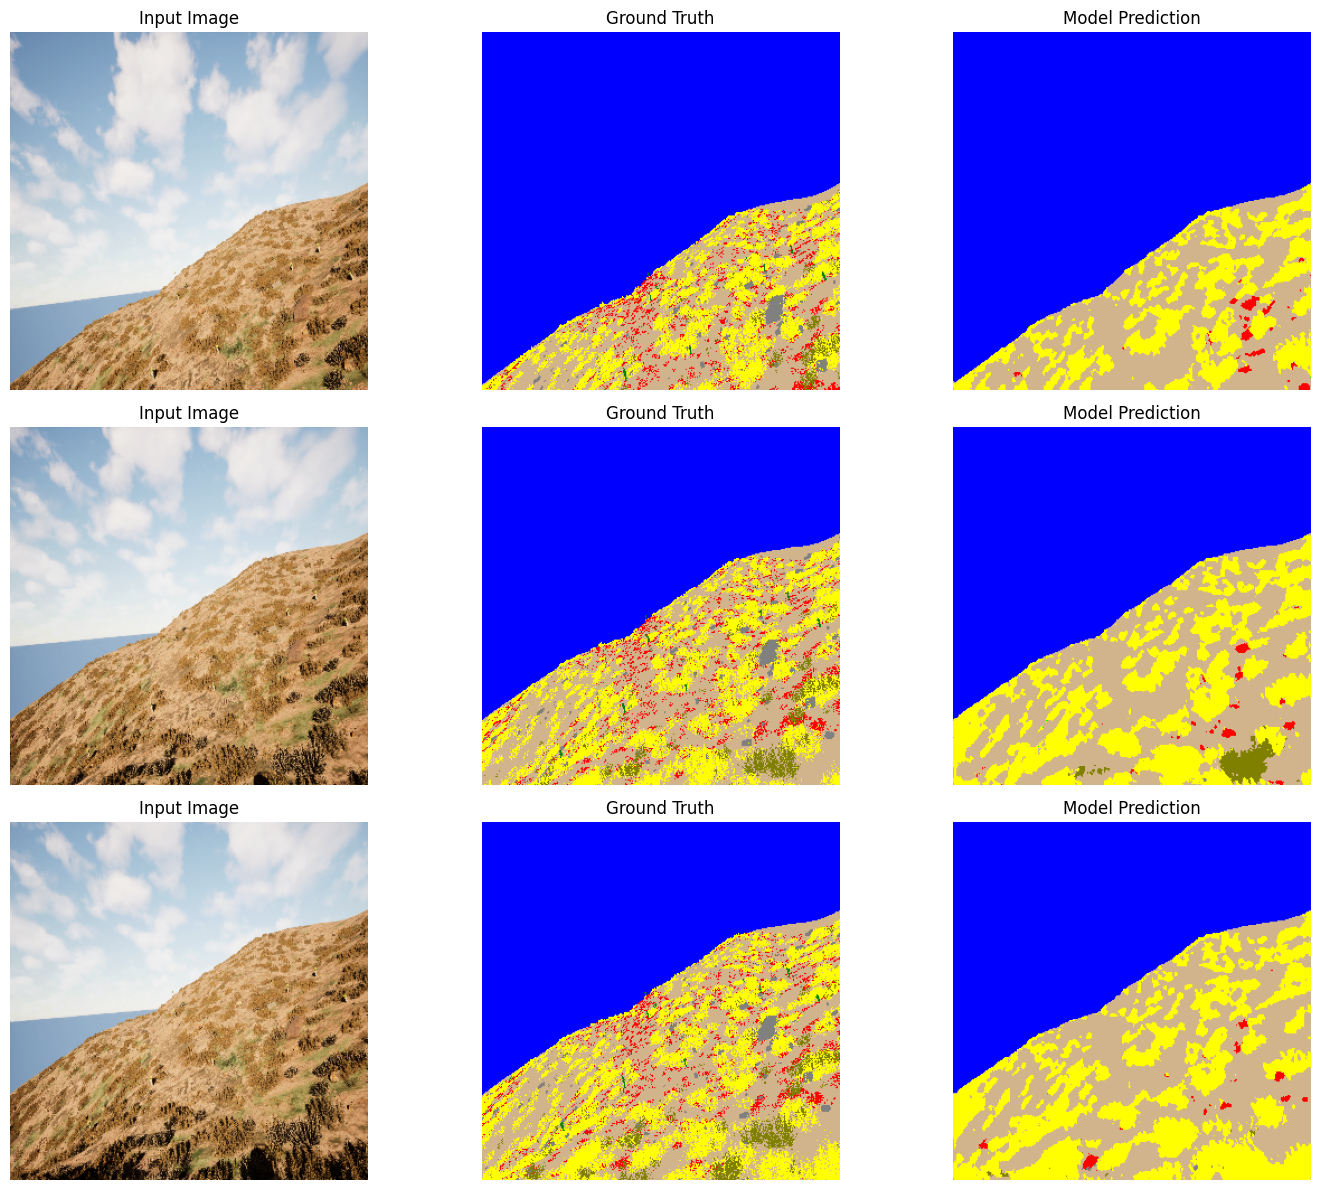

 Saved to 'final_report_images.png'


In [10]:
# Visualization & Report 
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

if 'val_loader' not in globals() or 'model' not in globals():
    print(" 'val_loader' or 'model' not found. Recreating them now...")
    
    # 1. Config
    ROOT_DIR = '/kaggle/input/offroad-data/Offroad_Segmentation_Training_Dataset'
    VAL_IMG = os.path.join(ROOT_DIR, 'val/Color_Images')
    VAL_MASK = os.path.join(ROOT_DIR, 'val/Segmentation')
    ENCODER = 'resnet34'
    ENCODER_WEIGHTS = 'imagenet'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 2. Class Definitions
    CLASS_DICT = {
        "Trees": 100, "Lush Bushes": 200, "Dry Grass": 300, "Dry Bushes": 500,
        "Ground Clutter": 550, "Flowers": 600, "Logs": 700, "Rocks": 800,
        "Landscape": 7100, "Sky": 10000
    }
    ID_TO_INDEX = {v: k for k, v in enumerate(CLASS_DICT.values())}

    def map_mask_to_indices(mask_array):
        mask_indices = np.zeros(mask_array.shape, dtype=np.int64)
        for original_id, new_index in ID_TO_INDEX.items():
            mask_indices[mask_array == original_id] = new_index
        return mask_indices

    # 3. Dataset Class
    class OffroadDataset(Dataset):
        def __init__(self, img_dir, mask_dir, augmentation=None, preprocessing=None):
            self.img_dir = img_dir
            self.mask_dir = mask_dir
            self.augmentation = augmentation
            self.preprocessing = preprocessing
            self.images = sorted(os.listdir(img_dir))
            self.masks = sorted(os.listdir(mask_dir))

        def __len__(self): return len(self.images)

        def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.images[idx])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask_path = os.path.join(self.mask_dir, self.masks[idx])
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask = map_mask_to_indices(mask)
            if self.augmentation:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            return image, torch.as_tensor(mask, dtype=torch.long)

    # 4. Setup Loaders & Model
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    def to_tensor(x, **kwargs): return x.transpose(2, 0, 1).astype('float32')
    def get_preprocessing(preprocessing_fn):
        return A.Compose([A.Lambda(image=preprocessing_fn), A.Lambda(image=to_tensor)])
    def get_validation_augmentation(): return A.Compose([A.Resize(320, 320)])

    val_ds = OffroadDataset(VAL_IMG, VAL_MASK, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)
    
    model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=10, activation=None)
    model.to(DEVICE)
    print(" Recovery Complete.")


# 1. Load Weights (if available)
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
    print(" Loaded 'best_model.pth'")
else:
    print(" No 'best_model.pth' found. Using untrained model (Results will be bad).")

model.eval()

# 2. Define Colors
COLORS = np.array([
    [0, 255, 0],     # Trees (Green)
    [0, 128, 0],     # Lush Bushes (Dark Green)
    [255, 255, 0],   # Dry Grass (Yellow)
    [128, 128, 0],   # Dry Bushes (Olive)
    [255, 0, 0],     # Ground Clutter (Red)
    [255, 0, 255],   # Flowers (Magenta)
    [139, 69, 19],   # Logs (Brown)
    [128, 128, 128], # Rocks (Grey)
    [210, 180, 140], # Landscape (Tan)
    [0, 0, 255]      # Sky (Blue)
], dtype=np.uint8)

def colorize_mask(mask):
    if isinstance(mask, torch.Tensor): mask = mask.cpu().numpy()
    h, w = mask.shape[-2:]
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for id_val, color in enumerate(COLORS):
        img[mask == id_val] = color
    return img

# 3. Predict on one batch
data_iter = iter(val_loader)
images, masks = next(data_iter)
images = images.to('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    logits = model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# 4. Plot
num_imgs = 3
plt.figure(figsize=(15, 12))
print("Displaying Visualization...")

for i in range(num_imgs):
    # Input (Denormalize)
    plt.subplot(num_imgs, 3, i*3 + 1)
    img_show = images[i].permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = (img_show * std + mean)
    plt.imshow(np.clip(img_show, 0, 1))
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(num_imgs, 3, i*3 + 2)
    plt.imshow(colorize_mask(masks[i]))
    plt.title("Ground Truth")
    plt.axis('off')

    # Prediction
    plt.subplot(num_imgs, 3, i*3 + 3)
    plt.imshow(colorize_mask(preds[i]))
    plt.title("Model Prediction")
    plt.axis('off')

plt.tight_layout()
plt.savefig("final_report_images.png")
plt.show()
print(" Saved to 'final_report_images.png'")

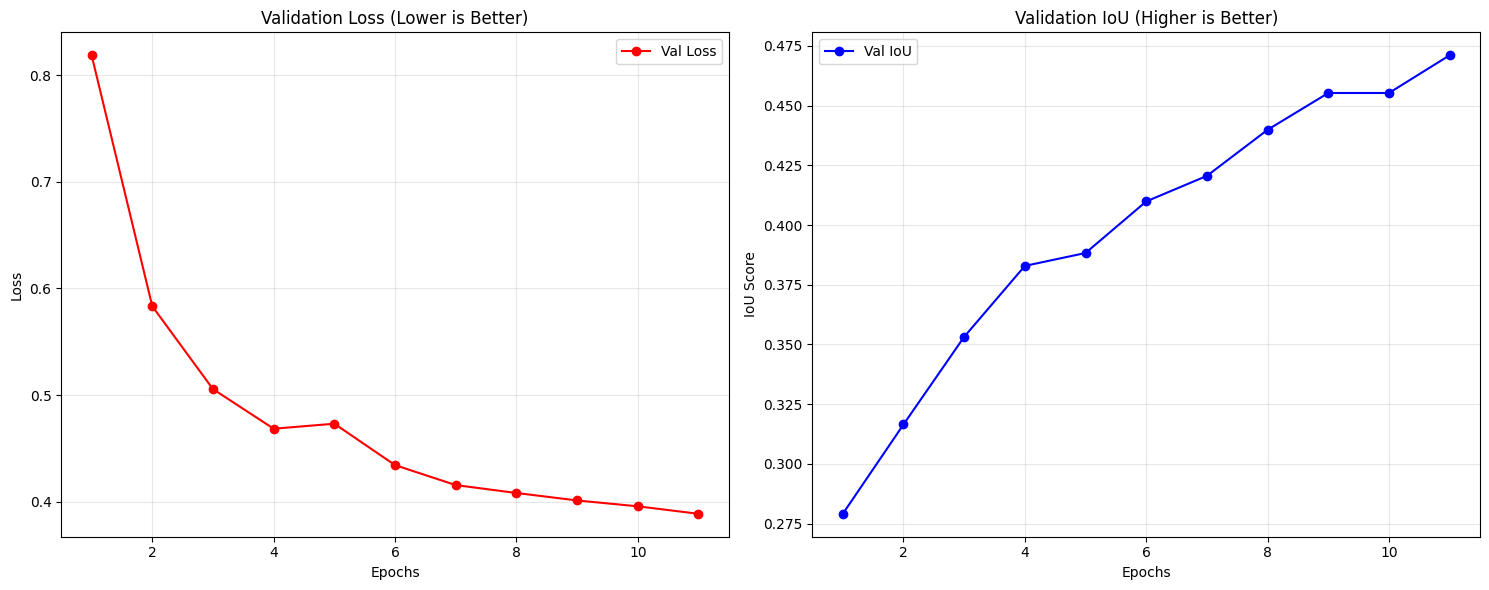

 Graph saved as 'training_graph.png'


In [11]:
# Plot Training History 
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, 12)
val_losses = [0.8185, 0.5833, 0.5057, 0.4686, 0.4733, 0.4345, 0.4158, 0.4084, 0.4014, 0.3959, 0.3889]
val_ious =   [0.2791, 0.3165, 0.3532, 0.3829, 0.3883, 0.4099, 0.4206, 0.4399, 0.4553, 0.4553, 0.4711]

# Plotting
plt.figure(figsize=(15, 6))

# Subplot 1: Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
plt.title("Validation Loss (Lower is Better)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: Validation IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, val_ious, 'b-o', label='Val IoU')
plt.title("Validation IoU (Higher is Better)")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("training_graph.png")
plt.show()

print(" Graph saved as 'training_graph.png'")

In [12]:
#  Full Validation Run & Submission Packaging
import os
import torch
import cv2
import shutil
import numpy as np
from tqdm import tqdm

# 1. Setup Folders
OUTPUT_DIR = "final_predictions"
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

print(f" Processing entire Validation Set into '{OUTPUT_DIR}'...")

# 2. Load Best Model
if not 'model' in globals():
    # Re-init if missing
    import segmentation_models_pytorch as smp
    model = smp.Unet(encoder_name='resnet34', classes=10, activation=None)
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
    print(" Loaded Weights from 'best_model.pth'")
else:
    print(" WARNING: Using untrained model weights!")

model.eval()

# 3. Define Colors
COLORS = np.array([
    [0, 255, 0], [0, 128, 0], [255, 255, 0], [128, 128, 0],
    [255, 0, 0], [255, 0, 255], [139, 69, 19], [128, 128, 128],
    [210, 180, 140], [0, 0, 255]
], dtype=np.uint8)

def colorize_mask(mask_2d):
    # mask_2d: (H, W) -> (H, W, 3)
    h, w = mask_2d.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for id_val, color in enumerate(COLORS):
        img[mask_2d == id_val] = color
    # Convert RGB to BGR for OpenCV saving
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# 4. Metric Tracker
iou_scores = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 5. Run Inference on All Images
idx = 0
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Saving Predictions"):
        images = images.to(device)
        masks = masks.to(device)
        
        # Predict
        logits = model(images)
        preds = torch.argmax(logits, dim=1) # (B, H, W)
        
        # Calculate Batch IoU
        # (Simplified IoU logic for tracking)
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat == masks_flat).sum().item()
        union = len(preds_flat)
        
        
        # Save Images
        for i in range(len(images)):
            # Get Prediction Mask
            pred_mask = preds[i].cpu().numpy().astype(np.uint8)
            colorized_pred = colorize_mask(pred_mask)
            
            # Save to file
            filename = f"pred_{idx:04d}.png"
            save_path = os.path.join(OUTPUT_DIR, filename)
            cv2.imwrite(save_path, colorized_pred)
            idx += 1

print(f"\n Saved {idx} prediction images to '{OUTPUT_DIR}'")

# 6. Create Zip File
print(" Zipping files for download...")
submission_files = ["best_model.pth", "final_report_images.png", "training_graph.png"]

# Create a clean folder for the zip
zip_folder = "submission_package"
if os.path.exists(zip_folder): shutil.rmtree(zip_folder)
os.makedirs(zip_folder)

# Move predictions into it
shutil.move(OUTPUT_DIR, os.path.join(zip_folder, "predictions"))

# Copy model and graphs
for f in submission_files:
    if os.path.exists(f):
        shutil.copy(f, os.path.join(zip_folder, f))

# Zip it
shutil.make_archive("submission", 'zip', zip_folder)

print("\n DONE! Download 'submission.zip' from the Output tab.")

 Processing entire Validation Set into 'final_predictions'...
 Loaded Weights from 'best_model.pth'


Saving Predictions: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]



 Saved 317 prediction images to 'final_predictions'
 Zipping files for download...

 DONE! Download 'submission.zip' from the Output tab.
